# 3. Hands on Reinforcement Learning

## 3.4 GLIE Monte-Carlo Control

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rc('text', usetex = True) # to use LaTeX

import gym
import numpy as np
from collections import defaultdict
from utils import plot_state_values
from utils import plot_policy

In [3]:
env = gym.make('Blackjack-v0')

### GLIE Monte-Carlo Control

In [4]:
def QtoV(Q):
    return {state: np.max(values) for state, values in Q.items()}

In [5]:
def epsilon_greedy_policy(env, Q, n_actions):
    def policy(state, epsilon):
        A = np.zeros_like(Q[state], dtype=np.float32)
        best_action = np.argmax(Q[state])
        A[:] = epsilon/n_actions
        A[best_action] = 1 - epsilon + epsilon/n_actions
        return A
    return policy

In [6]:
def generate_episode_from_behavior_policy(env, pi, epsilon):
    state = env.reset()
    episode = []
    while True:
        probs = pi(state, epsilon)
        action = np.random.choice(np.arange(len(probs)), p=probs)
        next_state, reward, terminate, _ = env.step(action)
        episode.append((state, action, reward))
        if terminate:
            break
            
        state = next_state
    
    return episode

In [7]:
def MC_GLIE(env, generate_episode, gamma, episodes):
    n_actions = env.action_space.n
    
    # initialize arbitrarily pi, Q, N
    Q = defaultdict(lambda: np.zeros(n_actions))
    N = defaultdict(lambda: np.zeros(n_actions))
    pi = epsilon_greedy_policy(env, Q, n_actions)
    
    for episode in range(episodes):
        epsilon = (1 / ((episode / 8000) + 1))
        trajectory = generate_episode(env, pi, epsilon)
        G, T = 0, len(trajectory)
        
        for i in range(T-1, -1, -1):
            state, action, reward = trajectory[i]
            G += gamma**i * reward
            
            visited_state = set()
            if (state, action) not in visited_state:
                # append G to returns (s_t, a_t)
                N[state][action] += 1
                Q[state][action] += (1 / N[state][action]) * (G - Q[state][action])
                visited_state.add((state, action))
    
    # retrieve the policy using argmax_a[Q(s,a)]
    policy = {}
    for state, rewards in Q.items():
        policy[state] = np.argmax(rewards)
    
    return Q, policy

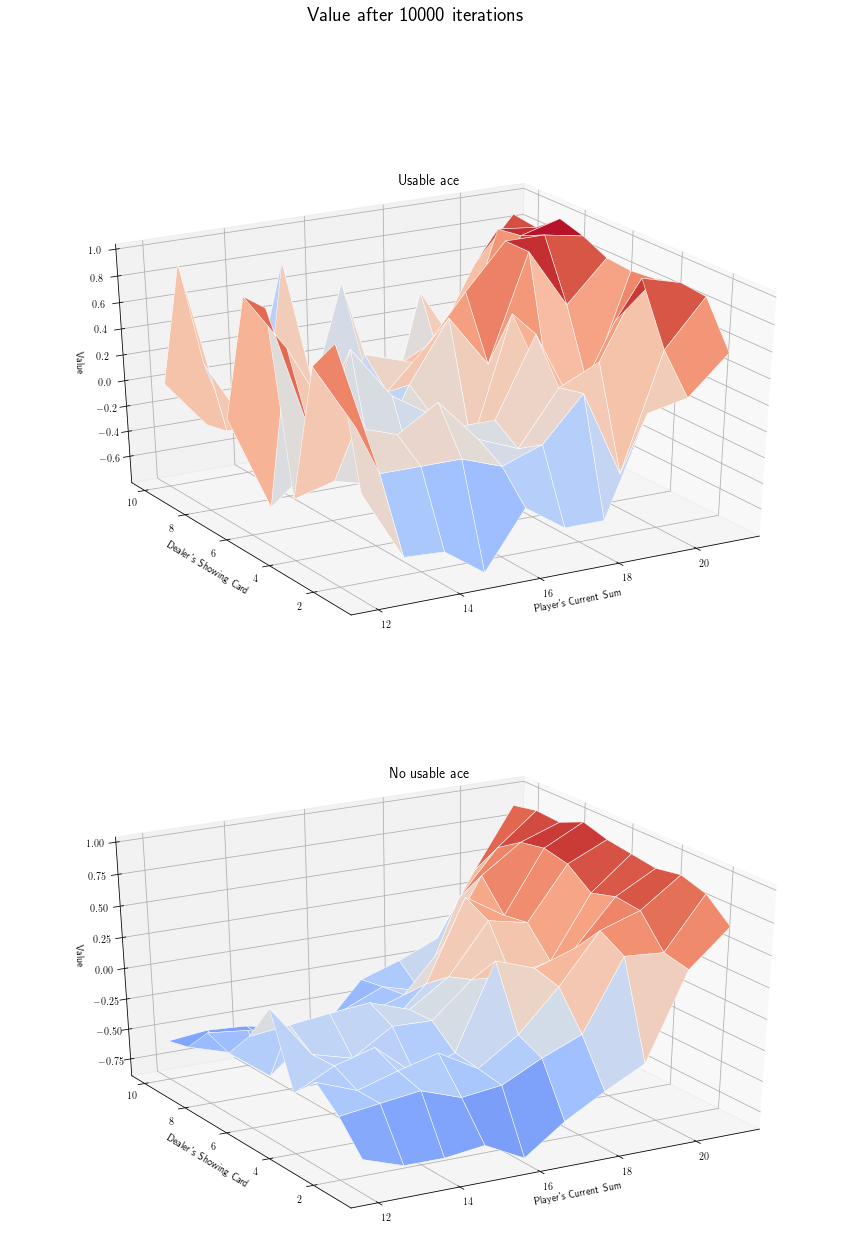

In [8]:
n_episodes = 10000
Q, pi = MC_GLIE(env, generate_episode_from_behavior_policy,
                1.0, n_episodes)
V = QtoV(Q)
plot_state_values(V, n_episodes)

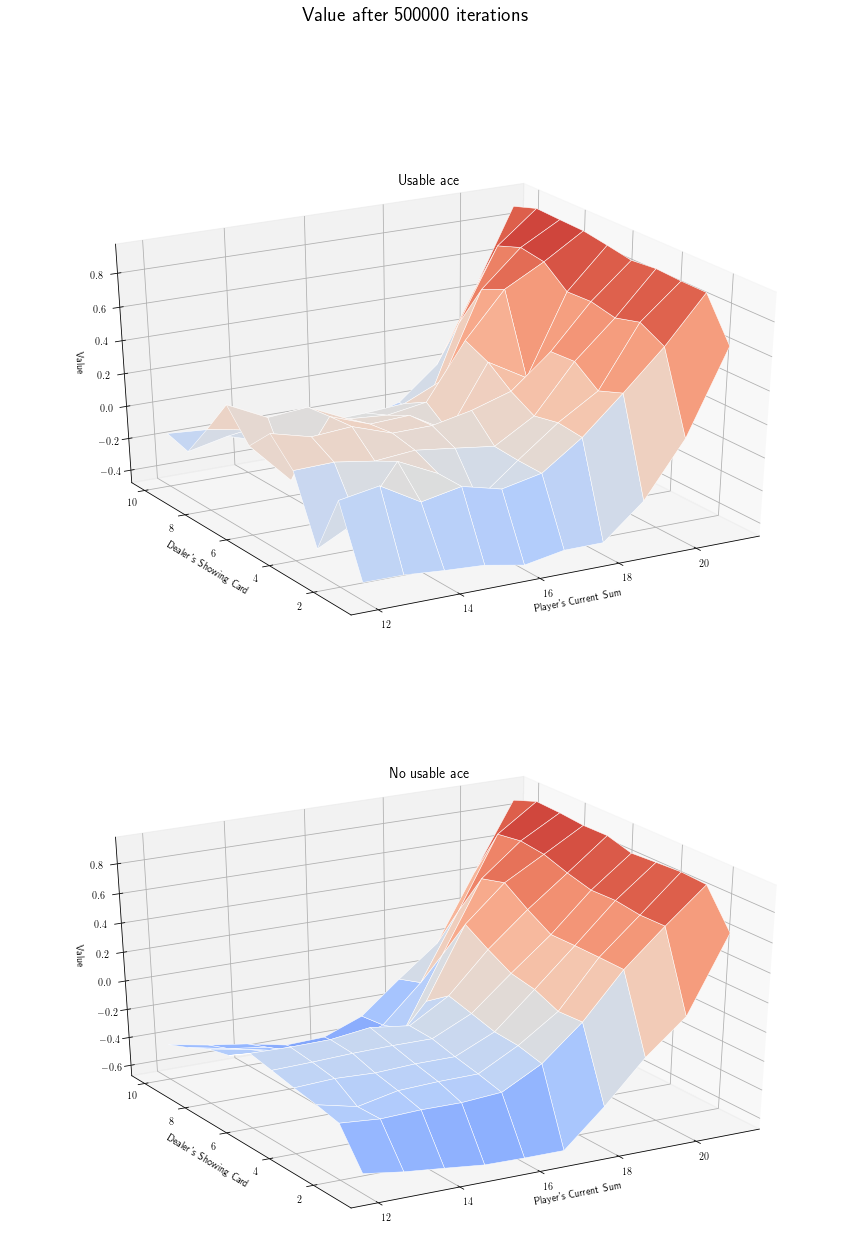

In [9]:
n_episodes = 500000
Q, pi = MC_GLIE(env, generate_episode_from_behavior_policy,
                1.0, n_episodes)
V = QtoV(Q)
plot_state_values(V, n_episodes)

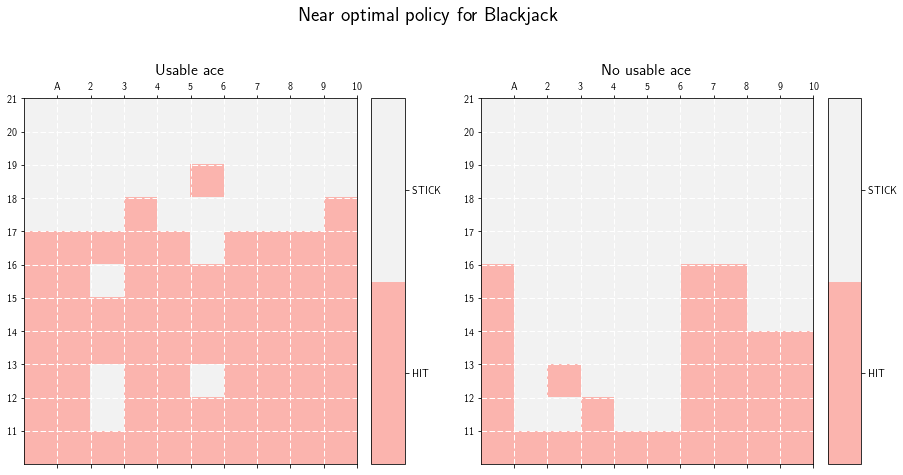

In [11]:
plot_policy(pi, "Near optimal policy for Blackjack")